## Import some helpful libraries

In [1]:
import os     # operating system interfaces
import fnmatch
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib; print("NiBabel version is ", nib.__version__)
from nibabel.testing import data_path
import math
import pandas as pd
import sys
import h5py; print("H5py version is\t\t", h5py.__version__)
import sklearn; print("Scikit-learn version is\t", sklearn.__version__)
import tensorflow as tf; print("TensorFlow version is\t", tf.__version__)
import keras; print("Keras version is ", keras.__version__)
from tensorflow.keras import models, Input, Model
from tensorflow.keras.layers import Dense, Conv3D, Conv3DTranspose, MaxPooling3D, UpSampling3D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import TensorBoard

NiBabel version is  3.2.0
H5py version is		 2.10.0
Scikit-learn version is	 0.23.2
TensorFlow version is	 2.3.1
Keras version is  2.3.1


Using TensorFlow backend.


## Loading Dataset:

In [2]:
# example_filename = os.path.join(data_path, 'example4d.nii.gz')
print(os.getcwd())     # '/Users/shossein/GitHub/DTI_Clustering'
dirpath = os.chdir("/Users/shossein/anaconda3/envs/m36/lib/python3.6/site-packages/nibabel/tests/data/DTI")
print("\nDirectory is changed into:\n", os.getcwd(), "\n") 
sample_all = []
for sample in fnmatch.filter(os.listdir(dirpath), 'Pat_*_1-post.nii.gz'):
    sample_all.append(sample)
sample_num = len(sample_all)
print("There are", sample_num, "samples.\n")
sample_all.sort()
# print(*sample_all, sep='\t')

/Users/shossein/GitHub/DTI_Clustering

Directory is changed into:
 /Users/shossein/anaconda3/envs/m36/lib/python3.6/site-packages/nibabel/tests/data/DTI 

There are 124 samples.



## Validation and Training Dataset (randomly)

In [3]:
sample_val = random.sample(sample_all, 24)
sample_val.sort()
print(len(sample_val), "Validation samples are:\n")
print(*sample_val, sep='\t')
sample_train = [x for x in sample_all if x not in sample_val]
sample_train.sort()
print(len(sample_train), "Training samples are:\n")
# print(*sample_train, sep='\t')

24 Validation samples are:

Pat_100_1-post.nii.gz	Pat_101_1-post.nii.gz	Pat_113_1-post.nii.gz	Pat_116_1-post.nii.gz	Pat_121_1-post.nii.gz	Pat_127_1-post.nii.gz	Pat_14_1-post.nii.gz	Pat_16_1-post.nii.gz	Pat_18_1-post.nii.gz	Pat_31_1-post.nii.gz	Pat_37_1-post.nii.gz	Pat_42_1-post.nii.gz	Pat_45_1-post.nii.gz	Pat_46_1-post.nii.gz	Pat_50_1-post.nii.gz	Pat_52_1-post.nii.gz	Pat_54_1-post.nii.gz	Pat_59_1-post.nii.gz	Pat_62_1-post.nii.gz	Pat_69_1-post.nii.gz	Pat_78_1-post.nii.gz	Pat_84_1-post.nii.gz	Pat_96_1-post.nii.gz	Pat_9_1-post.nii.gz


## Combine datasets together

(100, 182, 218, 182, 1)


Text(0.5, 1, 'Center slices for image')

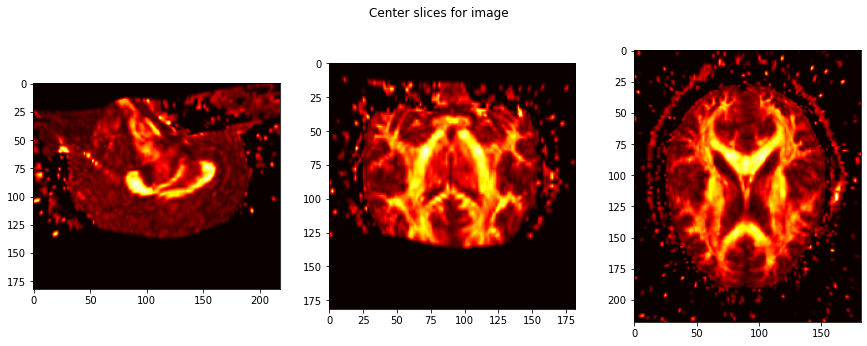

In [81]:
## Combine all train dateset together
data_combined = np.zeros((1, 182, 218, 182, 1))
for sample in sample_train:
#     print(sample)
    img = nib.load(sample)
    img_np = np.asanyarray(img.dataobj)         # Convert data into Numpy array format
    data_64 = np.float64(img_np)                # Convert numpayed data back into the original float64
    data_reshape = np.reshape(data_64, (1, 182, 218, 182, 1))
    data_combined = np.concatenate((data_combined, data_reshape), axis=0)
data_combined = np.delete(data_combined, 0, axis=0)
print("Shape of training dataset:", data_combined.shape)
train_data = data_combined

def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices), figsize=(15,5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="hot", origin="upper") # hot, Greys, gray
for m in range(data_combined.shape[0]):
    slice_0 = data_combined[m, 91, :, :, 0]
    slice_1 = data_combined[m, :, 109, :, 0]
    slice_2 = data_combined[m, :, :, 91, 0]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for image", x=0.5, y=1)

In [92]:
## Rescale train_data into [0:1]
print("Range of a sample of original training data:\tMin=", np.min(train_data[10, :, :, :, 0]), ",   Max=", np.max(train_data[10, :, :, :, 0]), "\n")
# for m in range(data_combined.shape[0]):
#     for x in range(data_combined.shape[1]):
#         for y in range(data_combined.shape[2]):
#             for z in range(data_combined.shape[3]):
#                 if data_combined[m,x,y,z] <= 0: data_combined[m,x,y,z] = 0
#                 if data_combined[m,x,y,z] > 1: data_combined[m,x,y,z] = 1
print("Range of a sample of original data:\t\tMin=", np.min(train_data[10, :, :, :, 0]), ",   Max=", np.max(train_data[10, :, :, :, 0]), "\n")

Range of a sample of original training data:	Min= 0.0 ,   Max= 0.9882298111915588 

Range of a sample of original data:		Min= 0.0 ,   Max= 0.9882298111915588 



Shape of validation dataset: (24, 182, 218, 182, 1)


Text(0.5, 1, 'Center slices for image')

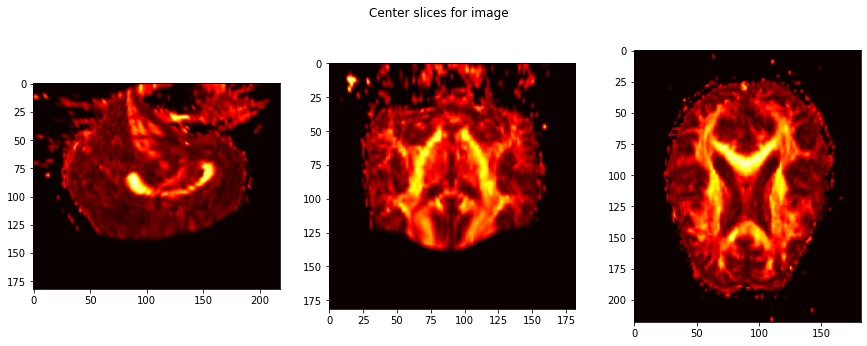

In [83]:
## Combine all validation dateset together
data_combined = np.zeros((1, 182, 218, 182, 1))
for sample in sample_val:
#     print(sample)
    img = nib.load(sample)
    img_np = np.asanyarray(img.dataobj)         # Convert data into Numpy array format
    data_64 = np.float64(img_np)                # Convert numpayed data back into the original float64
    data_reshape = np.reshape(data_64, (1, 182, 218, 182, 1))
    data_combined = np.concatenate((data_combined, data_reshape), axis=0)
data_combined = np.delete(data_combined, 0, axis=0)
print("Shape of validation dataset:", data_combined.shape)
valid_data = data_combined

for m in range(data_combined.shape[0]):
    slice_0 = data_combined[m, 91, :, :, 0]
    slice_1 = data_combined[m, :, 109, :, 0]
    slice_2 = data_combined[m, :, :, 91, 0]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for image", x=0.5, y=1)

In [94]:
## Rescale valid_data into [0:1]
print("Range of a sample of original validation data:\tMin=", np.min(valid_data[10, :, :, :, 0]), ",   Max=", np.max(valid_data[10, :, :, :, 0]), "\n")
for m in range(valid_data.shape[0]):
    for x in range(valid_data.shape[1]):
        for y in range(valid_data.shape[2]):
            for z in range(valid_data.shape[3]):
                if valid_data[m,x,y,z] <= 0: valid_data[m,x,y,z] = 0
                if valid_data[m,x,y,z] > 1: valid_data[m,x,y,z] = 1
print("Range of a sample of original data:\t\tMin=", np.min(valid_data[10, :, :, :, 0]), ",   Max=", np.max(valid_data[10, :, :, :, 0]), "\n")

Range of a sample of original validation data:	Min= 0.0 ,   Max= 1.0 

Range of a sample of original data:		Min= 0.0 ,   Max= 1.0 



## Model Design

In [95]:
## Define parameters:

IMAGE_HEIGHT = data_combined.shape[1]
IMAGE_WIDTH = data_combined.shape[2]
IMAGE_DEPTH = data_combined.shape[3]
batch_size = 32
data_shape = [1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
input_shape = [batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
print("input-layer shape:", input_shape)

## Encoder
input_img = Input(shape=(182, 218, 182, 1))
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same', name='Conv1')(input_img)
x = MaxPooling3D((13, 13, 13), padding='same')(x)
x = Conv3D(8, (3, 3, 3), activation='relu', padding='same', name='Conv2')(x)
encoded = MaxPooling3D((7, 7, 7), padding='same')(x)
## at this point the representation is (2, 3, 2, 8) i.e. 96-dimensional instead of 7,221,032

## Decoder
x = Conv3DTranspose(4, (3, 3, 3), activation='relu', padding='same', name='DeConv3')(encoded)
x = UpSampling3D((7, 6, 7))(x)
x = Conv3DTranspose(8, (3, 3, 3), activation='relu', padding='same', name='DeConv4')(x)
x = UpSampling3D((13, 12, 13))(x)
decoded = Conv3DTranspose(1, (1, 3, 1), activation='sigmoid', padding='valid', name='DeConv5')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
autoencoder.summary()

input-layer shape: [32, 182, 218, 182, 1]
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 182, 218, 182, 1) 0         
_________________________________________________________________
Conv1 (Conv3D)               (None, 182, 218, 182, 16) 448       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 14, 17, 14, 16)    0         
_________________________________________________________________
Conv2 (Conv3D)               (None, 14, 17, 14, 8)     3464      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 2, 3, 2, 8)        0         
_________________________________________________________________
DeConv3 (Conv3DTranspose)    (None, 2, 3, 2, 4)        868       
_________________________________________________________________
up_sampling3

## Model Training

In [ ]:
## Tensorboard callback
%load_ext tensorboard
# %reload_ext tensorboard
logs_base_dir = "./CAE_logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}
logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

## Midel Fit
autoencoder.fit(train_data, train_data, epochs=20, batch_size=batch_size, shuffle=True, \
                validation_data=(valid_data, valid_data), callbacks=[tensorboard_callback], verbose=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 56871), started 0:00:20 ago. (Use '!kill 56871' to kill it.)

Epoch 1/20
